In [32]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from functions import *
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from synapse.ml.isolationforest import *
from synapse.ml.explainers import *
from synapse.ml.core.platform import *
from synapse.ml.isolationforest import *
import branca.colormap as cm
import folium
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
spark = SparkSession.builder \
   .master("local") \
   .appName("anomaly_detection") \
   .config("spark.executor.memory", "8gb") \
   .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8") \
   .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
   .getOrCreate()
# i due config aggiuntivi servono per usare synapseml
sc = spark.sparkContext

In [ ]:
def get_outlier_scores(timeseries_df, features, isolation_forest):
    """
    Funzione che, dato un dataframe che rappresenta una time series multivariata, addestra un modello di isolation forest, e restituisce il dataframe dei risultati, e il modello
    """
    # seleziono le feature che mi servono e le casto a double
    to_keep = [timeseries_df[col].cast(DoubleType()).alias(col) for col in features if col != 'road_condition']
    df = timeseries_df.select(to_keep)
    # creo il vettore delle feature
    vectorizer = VectorAssembler(inputCols=[col for col in df.columns if col not in ['latitude','longitude','speed','timestep']], outputCol='features')
    df_proc = vectorizer.transform(df)
    if_model = isolation_forest.fit(df_proc)
    result = if_model.transform(df_proc)
    return result, if_model
    

In [ ]:
# faccio outlier detection sui tre driving process dello Scenario 1
pvs1_timeseries = dataset_preparation('PVS1', spark, 'data')
pvs4_timeseries = dataset_preparation('PVS4', spark, 'data')
pvs7_timeseries = dataset_preparation('PVS7', spark, 'data')

In [44]:
# solo per prendere i nomi delle colonne e usare solo le feature rimaste dalla feature selection
pvs1_tabular = spark.read.option("header", True).option("inferSchema", True).csv('processed_data/PVS1') 

In [ ]:
# prendo la lista delle colonne rimaste dalla feature selection rimuovendo il prefisso avg e std
to_keep = ['timestep'] + list(set([col[4:] if col[:3] in ['avg','std'] else col for col in pvs1_tabular.columns]))

In [ ]:
# parametri della isolation forest
contamination = 0.005
num_estimators = 500
max_samples = 0.01
max_features = 1.0

iforest = (
    IsolationForest()
    .setNumEstimators(num_estimators)
    .setBootstrap(False)
    .setMaxSamples(max_samples)
    .setMaxFeatures(max_features)
    .setFeaturesCol("features")
    .setPredictionCol("predictedLabel")
    .setScoreCol("outlierScore")
    .setContamination(contamination)
    .setContaminationError(0.01 * contamination)
    .setRandomSeed(1)
)

In [ ]:
# faccio outlier detection sui tre driving process dello Scenario 1
pvs1_outlier, pvs1_if_model = get_outlier_scores(pvs1_timeseries, to_keep, iforest)
pvs4_outlier, pvs4_if_model = get_outlier_scores(pvs4_timeseries, to_keep, iforest)
pvs7_outlier, pvs7_if_model = get_outlier_scores(pvs7_timeseries, to_keep, iforest)

In [48]:
pvs1_outlier.show(3)

+--------+-------------------+-------------------+------------------+------------------------+------------------------+------------------+-------------------+------------------+------------------------+-----------+-----------------+------------------------+------------------------+------------------------+------------------------+-------------------+------------------------+-----------------+-------------------+------------------+------------------+-----------------------+-----------------------+--------------------+------------------------+------------------------+--------------------+-------------------+--------------+
|timestep|  acc_x_dashboard_L|  mag_y_dashboard_L|  temp_dashboard_L|acc_z_below_suspension_L|mag_z_above_suspension_L|gyro_z_dashboard_L|  acc_y_dashboard_L|         longitude|mag_y_above_suspension_L|      speed|acc_z_dashboard_R|mag_z_above_suspension_R|acc_z_above_suspension_R|mag_y_above_suspension_R|mag_x_above_suspension_R|           latitude|mag_x_above_suspens

## Driving Process POV Anomalies Detection

In questa parte dell'analisi gli outlier delle time series sono studianti in parallelo, per cercare di capire quante anomalie siano specifiche del driving process e quali invece sono presenti in tutti e tre

In [ ]:
# prendo le feature che mi servono come input per la mia funzione di approssimazione delle time series, perndo anche la speed perchè mi serve per calcolare la distanza percorsa
feat_funct = [F.avg('outlierScore').alias('outlierScore'), F.avg('speed').alias('speed'), F.max('predictedLabel').alias('label')]
approx_outlier_pvs1 = approximate_ts(pvs1_outlier, feat_funct, 200, label=False)
approx_outlier_pvs4 = approximate_ts(pvs4_outlier, feat_funct, 200, label=False)
approx_outlier_pvs7 = approximate_ts(pvs7_outlier, feat_funct, 200, label=False)

In [ ]:
# lunghezza time series approssimate
approx_outlier_pvs1.count(), approx_outlier_pvs4.count(), approx_outlier_pvs7.count()

(721, 663, 643)

In [ ]:
# porto tutto in Pandas
approx_outlier_pvs1_pd = approx_outlier_pvs1.toPandas()
approx_outlier_pvs4_pd = approx_outlier_pvs4.toPandas()
approx_outlier_pvs7_pd = approx_outlier_pvs7.toPandas()

In [ ]:
# calcolo la distanza come avevo fatto in fase di data exploration
approx_outlier_pvs1_pd['distance'] = np.array([approx_outlier_pvs1_pd.iloc[i]['speed']+sum(approx_outlier_pvs1_pd[:i]['speed']) for i in range(len(approx_outlier_pvs1_pd))]) * 2
approx_outlier_pvs4_pd['distance'] = np.array([approx_outlier_pvs4_pd.iloc[i]['speed']+sum(approx_outlier_pvs4_pd[:i]['speed']) for i in range(len(approx_outlier_pvs4_pd))]) * 2
approx_outlier_pvs7_pd['distance'] = np.array([approx_outlier_pvs7_pd.iloc[i]['speed']+sum(approx_outlier_pvs7_pd[:i]['speed']) for i in range(len(approx_outlier_pvs7_pd))]) * 2

In [ ]:
approx_outlier_pvs1_pd['distance'].iloc[-1], approx_outlier_pvs4_pd['distance'].iloc[-1], approx_outlier_pvs7_pd['distance'].iloc[-1]

(13765.344326236747, 13763.081803337749, 13746.620745237531)

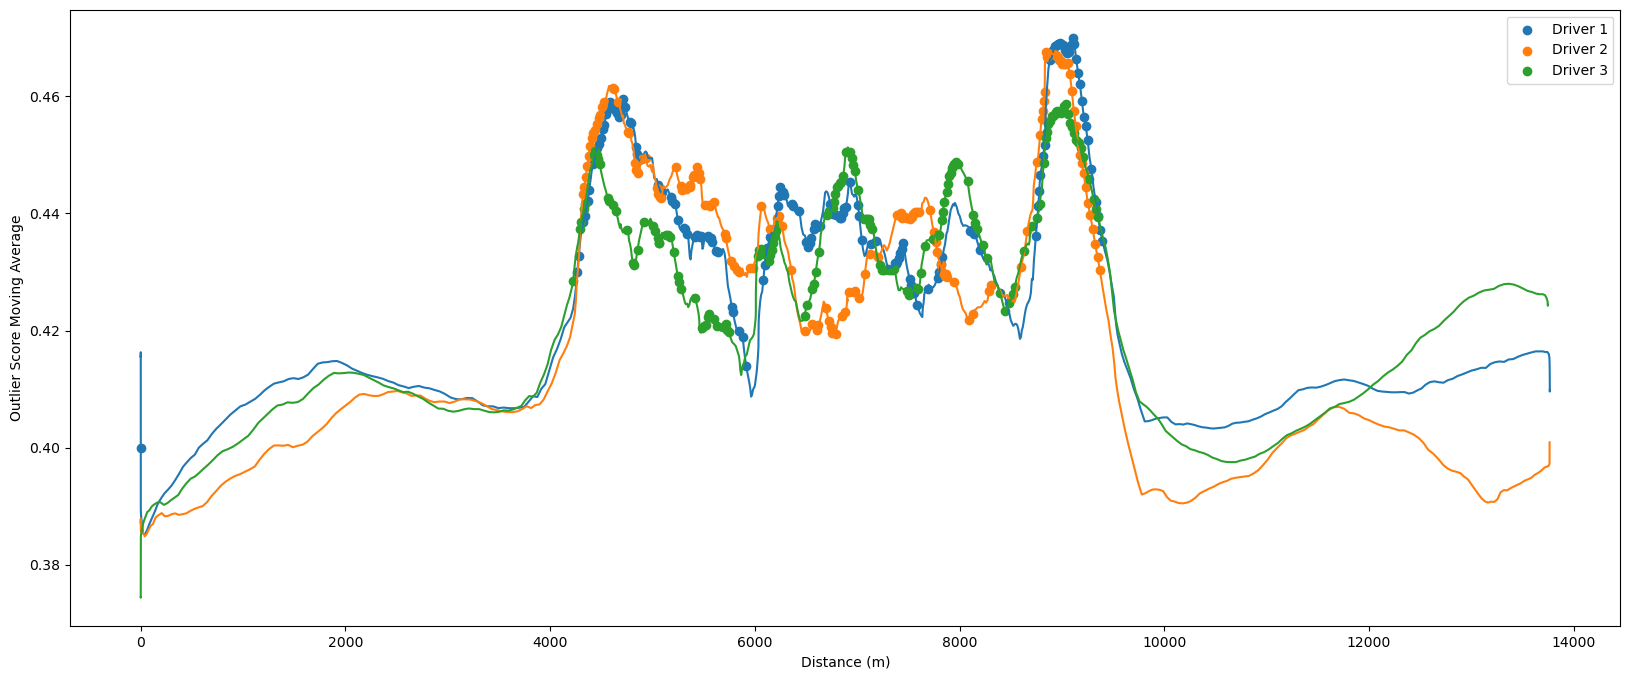

In [ ]:
# faccio denoising con la media mobile
approx_outlier_pvs1_pd['denoised_os'] = moving_average(approx_outlier_pvs1_pd['outlierScore'], 32)
approx_outlier_pvs4_pd['denoised_os'] = moving_average(approx_outlier_pvs4_pd['outlierScore'], 32)
approx_outlier_pvs7_pd['denoised_os'] = moving_average(approx_outlier_pvs7_pd['outlierScore'], 32)


plt.figure(figsize=(20,8))
plt.plot(approx_outlier_pvs1_pd['distance'], approx_outlier_pvs1_pd['denoised_os'])
plt.plot(approx_outlier_pvs4_pd['distance'], approx_outlier_pvs4_pd['denoised_os'])
plt.plot(approx_outlier_pvs7_pd['distance'], approx_outlier_pvs7_pd['denoised_os'])

plt.scatter(approx_outlier_pvs1_pd[approx_outlier_pvs1_pd['label'] == 1]['distance'], approx_outlier_pvs1_pd[approx_outlier_pvs1_pd['label'] == 1]['denoised_os'], label='Driver 1')
plt.scatter(approx_outlier_pvs4_pd[approx_outlier_pvs4_pd['label'] == 1]['distance'], approx_outlier_pvs4_pd[approx_outlier_pvs4_pd['label'] == 1]['denoised_os'], label='Driver 2')
plt.scatter(approx_outlier_pvs7_pd[approx_outlier_pvs7_pd['label'] == 1]['distance'], approx_outlier_pvs7_pd[approx_outlier_pvs7_pd['label'] == 1]['denoised_os'], label='Driver 3')

plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('Outlier Score Moving Average')
plt.show()

## General Anomalies Detection

Ora cerco di studiare gli outlier in comune per tutti e tre i driving process

In [ ]:
# seleziono solo le osservazioni etichettate come animalie
pvs1_anomalies = pvs1_outlier.where(F.col('predictedLabel') == 1.0).select(['timestep', 'longitude', 'latitude','outlierScore'])
pvs4_anomalies = pvs4_outlier.where(F.col('predictedLabel') == 1.0).select(['timestep', 'longitude', 'latitude','outlierScore'])
pvs7_anomalies = pvs7_outlier.where(F.col('predictedLabel') == 1.0).select(['timestep', 'longitude', 'latitude','outlierScore'])

In [ ]:
# il numero di anomalie per driving process (0.05% del totale delle osservazioni)
pvs1_anomalies.count(), pvs4_anomalies.count(), pvs7_anomalies.count()

(727, 669, 647)

In [ ]:
# approssimo le coordinate a 4 cifre decimali per poter fare una join spaziale tra le osservazioni con una certa tolleranza
pvs1_anomalies = pvs1_anomalies.withColumns({'proxy_long': F.round(F.col('longitude'),4), 'proxy_lat': F.round(F.col('latitude'),4)}) 
pvs4_anomalies = pvs4_anomalies.withColumns({'proxy_long': F.round(F.col('longitude'),4), 'proxy_lat': F.round(F.col('latitude'),4)})
pvs7_anomalies = pvs7_anomalies.withColumns({'proxy_long': F.round(F.col('longitude'),4), 'proxy_lat': F.round(F.col('latitude'),4)})

In [ ]:
# cambio i nomi degli attributi per poterli distinguere dopo la join
for old_name in pvs1_anomalies.columns:
    if old_name not in ['proxy_long', 'proxy_lat']:
        pvs1_anomalies = pvs1_anomalies.withColumnRenamed(old_name, old_name+'1')
        pvs4_anomalies = pvs4_anomalies.withColumnRenamed(old_name, old_name+'4')
        pvs7_anomalies = pvs7_anomalies.withColumnRenamed(old_name, old_name+'7')

In [59]:
# in questo modo trovo i segmenti di strada identificati come anomali per tutti e tre i driving process
tot_anomalies = pvs1_anomalies.join(pvs4_anomalies, ['proxy_long', 'proxy_lat'], how='inner').join(pvs7_anomalies, ['proxy_long', 'proxy_lat'], how='inner')

In [60]:
# saranno presenti molti tratti di strada duplicati, per via del sampling rate del gps più lento di quello delle osservazioni dei sensori
tot_anomalies.count()

12975

In [61]:
# calcolo l'outlierScore medio, e le coordinate medie
tot_anomalies = tot_anomalies.withColumn('avgOutlierScore', (F.col('outlierScore1') + F.col('outlierScore4') + F.col('outlierScore7'))/3)
tot_anomalies = tot_anomalies.withColumn('avgLatitude', (F.col('latitude1') + F.col('latitude4') + F.col('latitude7'))/3)
tot_anomalies = tot_anomalies.withColumn('avgLongitude', (F.col('longitude1') + F.col('longitude4') + F.col('longitude7'))/3)

In [62]:
# rimuovo tutte le anomalie con coordinate duplicate
tot_anomalies = tot_anomalies.dropDuplicates(['avgLatitude', 'avgLongitude']).orderBy(F.col('avgOutlierScore').desc())

In [63]:
tot_anomalies.show(3)

+----------+---------+---------+-------------------+-------------------+------------------+---------+-------------------+------------------+------------------+---------+------------------+------------------+------------------+------------------+-------------------+------------------+
|proxy_long|proxy_lat|timestep1|         longitude1|          latitude1|     outlierScore1|timestep4|         longitude4|         latitude4|     outlierScore4|timestep7|        longitude7|         latitude7|     outlierScore7|   avgOutlierScore|        avgLatitude|      avgLongitude|
+----------+---------+---------+-------------------+-------------------+------------------+---------+-------------------+------------------+------------------+---------+------------------+------------------+------------------+------------------+-------------------+------------------+
|   -51.125| -27.6857| 111136.0|-51.125042101921146| -27.68567800844093|0.5681581831929501| 100049.0| -51.12504865277986|-27.68569261126161|0.584

In [ ]:
# numero di anomalie trovate
tot_anomalies.count()

92

In [65]:
anomalies_pd = tot_anomalies.select(['timestep1', 'avgLatitude','avgLongitude','avgOutlierScore']).toPandas()

In [66]:
anomalies_pd

,timestep1,avgLatitude,avgLongitude,avgOutlierScore
0,111076.0,-27.685683,-51.125043,0.568316
1,113366.0,-27.686621,-51.125087,0.565780
2,87928.0,-27.686676,-51.129424,0.563245
3,113261.0,-27.686598,-51.125096,0.561407
4,88391.0,-27.686392,-51.129572,0.558746
...,...,...,...,...
87,76964.0,-27.690800,-51.129185,0.534296
88,47092.0,-27.691789,-51.127913,0.533054
89,52263.0,-27.689931,-51.129108,0.532831
90,113177.0,-27.686510,-51.125127,0.532811


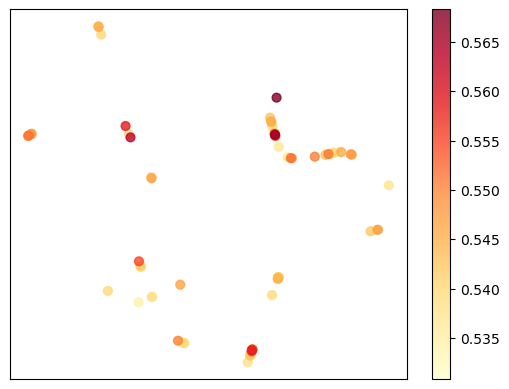

In [ ]:
# grafico di esempio, sul report sarà usato quello fatto con folium
anomalies_pd = anomalies_pd.sort_values('avgOutlierScore')
plt.scatter(anomalies_pd['avgLongitude'], anomalies_pd['avgLatitude'], c=anomalies_pd['avgOutlierScore'], cmap="YlOrRd",s=40, alpha=0.8)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [94]:
map_center = [anomalies_pd['avgLatitude'].mean(), anomalies_pd['avgLongitude'].mean()]
map = folium.Map(location=map_center, zoom_start=15, width=500, height=700)

min_speed = anomalies_pd['avgOutlierScore'].min()
max_speed = anomalies_pd['avgOutlierScore'].max()
colormap = cm.LinearColormap(['yellow', 'orange', 'red'], vmin=min_speed, vmax=max_speed, caption="Outlier Score")

for _, row in anomalies_pd.iterrows():
    folium.CircleMarker(
        location=(row['avgLatitude'], row['avgLongitude']),
        radius=5,
        color=colormap(row['avgOutlierScore']), 
        fill=True,
        fill_color=colormap(row['avgOutlierScore']),
        tooltip=row['timestep1'],
        fill_opacity=0.8,
    ).add_to(map)

colormap.add_to(map)

map

# Outlier Score Global Explainability

Per analizzare l'impatto delle features nell'assegnazione dell'outlier score, addestro un decision tree regressor, senza parametri per evitare l'overfitting, e usando l'outlier score come label, in questo modo posso analizzare la feature importance del modello.

In [69]:
dt = DecisionTreeRegressor(labelCol='outlierScore')
dt_model1 = dt.fit(pvs1_outlier)
dt_model4 = dt.fit(pvs4_outlier)
dt_model7 = dt.fit(pvs7_outlier)

In [71]:
prediction1 = dt_model1.transform(pvs1_outlier)
prediction4 = dt_model4.transform(pvs4_outlier)
prediction7 = dt_model7.transform(pvs7_outlier)

preds = [prediction1, prediction4, prediction7]

In [ ]:
# valuto il regressore per capire se ha fittato bene i dati
evaluator = RegressionEvaluator(labelCol="outlierScore", predictionCol="prediction", metricName="r2")

i = 1
for pred in preds:
    r2_score = evaluator.evaluate(pred)
    print(f'r2 sul training set per pvs{i}: {r2_score}')
    i+=3

r2 sul training set per pvs1: 0.46088307608764345
r2 sul training set per pvs4: 0.5105210595438779
r2 sul training set per pvs7: 0.41612022402273574


In [76]:
features_names = [col for col in pvs1_timeseries.columns if col not in ['latitude','longitude','speed','timestep']]
feat_imp = [(name,(val1+val4+val7)/3) for name,val1,val4,val7 in zip(features_names, dt_model1.featureImportances, dt_model4.featureImportances, dt_model7.featureImportances)]

In [80]:
imp = pd.DataFrame(sorted(feat_imp, key= lambda x: x[1], reverse=False))

[]

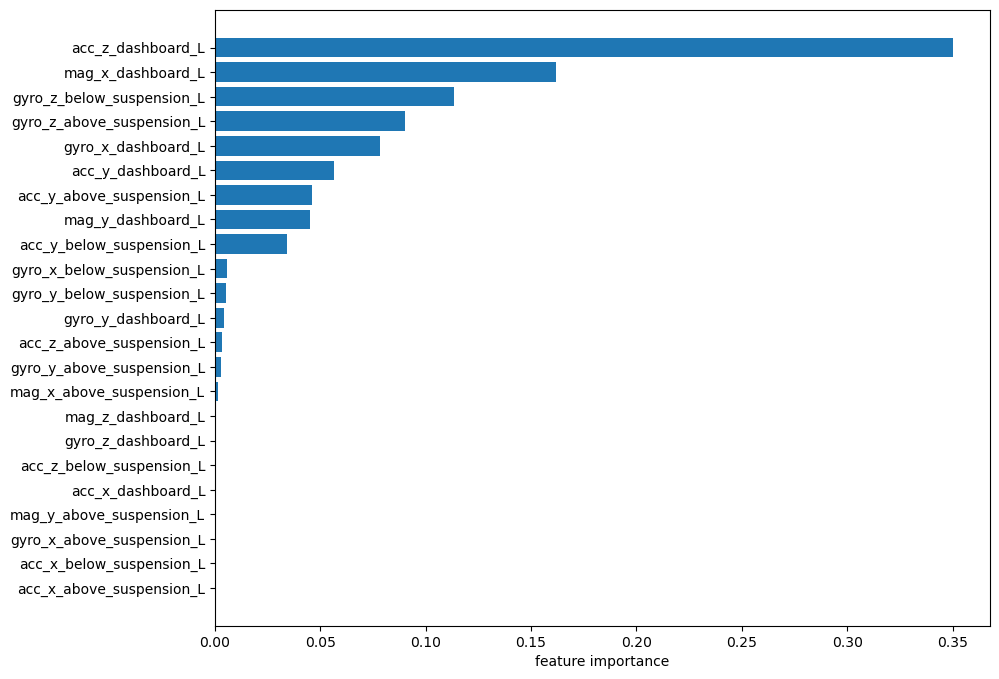

In [81]:
plt.figure(figsize=(10,8))
plt.barh(imp[0], imp[1])
plt.xlabel('feature importance')
plt.plot()